In [1]:
import os
import pickle
import json
import numpy as np
from keras.layers import Input,Dense
from keras.models import Model
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import decode_predictions

from keras.layers import AveragePooling2D
from keras.preprocessing import image
from keras.models import Model
import tensorflow as tf
sess = tf.Session()
from keras import backend as K
K.set_session(sess)
from keras.layers.normalization import BatchNormalization
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
%matplotlib inline

/home/parmeet/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/parmeet/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
num_labels = 228 + 1

In [3]:
#getting annotations from file
with open('train.json') as train_json:
    train_data = json.load(train_json)
label_mapping = {}
for obj in train_data['annotations']:
    label_mapping[obj['imageId']] = obj['labelId']

In [4]:
#getting annotations from validation file
with open('validation.json') as val_json:
    validation_data = json.load(val_json)
validation_label_mapping = {}
for obj in train_data['annotations']:
    validation_label_mapping[obj['imageId']] = obj['labelId']

In [5]:
#getting annotations from file
with open('test.json') as test_json:
    test_data = json.load(test_json)
len(test_data['images'])

39706

In [6]:
base_model = ResNet50(
    input_shape=(224,224,3),
    weights='imagenet',
    include_top=True
)

model = Model(
    inputs=base_model.input,
    outputs=base_model.layers[-2].output
)

In [7]:
def extract_image(image_path,model):
        img = image.load_img(image_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        
        return model.predict(x)

In [8]:
image_input = Input(shape=(2048,))
middle = Dense(2048,activation='relu')(image_input)
middle = BatchNormalization()(image_input)
middle = Dense(2048,activation='relu')(image_input)
middle = BatchNormalization()(middle)
output = Dense(num_labels,activation='sigmoid')(middle)
model_dense = Model(image_input, output)
model_dense.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [9]:
def extract_features_test(folder):
    if os.path.isfile(folder+"_data_resnet50.pckl"):
        with open(folder+"_data_resnet50.pckl",'rb') as write_file:
            image_features,img_ids = pickle.load(write_file)
    else:
        with open(folder+"_data_resnet50.pckl",'wb') as output:
            with open('test.json') as test_json:
                test_data = json.load(test_json)
            num_test_images = len(test_data['images'])

            image_features = []
            img_ids = []
            for i in range(num_test_images):
                print(i)
                try:
                    features = extract_image('data/test_images/'+str(i+1)+".jpeg",model)
                except:
                    print("Excpetion")
                    features = np.random.randn(2048)
                features = np.array(features).reshape(1,-1)
                image_features.append(features)
                img_ids.append(i+1)
            pickle.dump((image_features,img_ids),output)
    return image_features,img_ids

In [13]:
def extract_features(folder,validation_label_mapping):
    if os.path.isfile(folder+"_data_resnet50.pckl"):
        with open(folder+"_data_resnet50.pckl",'rb') as write_file:
            validation_features,val_labels = pickle.load(write_file)
    else:
        with open(folder+"_data_resnet50.pckl",'wb') as output:
            validation_files = os.listdir('data/'+folder+'_images/')
            num_validation_files = len(validation_files)
            batch_sz = 100
            num_batches = int(num_validation_files/batch_sz)

            print("Number of batches",num_batches)
            validation_features = []
            validation_labels = []
            for idx,file in enumerate(validation_files):
                print(idx)
                try:
                    image_feature = extract_image('data/'+folder+'_images/'+file,model)
                    validation_features.append(image_feature)
                    validation_labels.append(validation_label_mapping[file.split(".")[0]])
                except Exception as ex:
                    print("exception catching",ex)
            val_labels = np.zeros((len(validation_labels),num_labels))
            for idx,labs in enumerate(validation_labels):
                val_labels[idx][list(map(int, labs))] = 1        
            pickle.dump((validation_features,val_labels),output)
    return validation_features,val_labels

In [11]:
validation_features,validation_labels = extract_features('validation',validation_label_mapping)
train_features,train_labels = extract_features('train',label_mapping)
test_features,test_ids = extract_features_test('test')

In [14]:
validation_features,validation_labels = extract_features('validation',validation_label_mapping)
test_features,test_ids = extract_features_test('test')

In [79]:
train_files = os.listdir('data/train_images/')
num_train_files = len(train_files)
batch_sz = 100
num_batches = int(num_train_files/batch_sz)

scores = []
print("Number of batches",num_batches)
epochs = 4
for epoch in range(epochs):
    for i in range(num_batches):
        print("Batch number",i)
        batch_features = np.squeeze(np.array(train_features),axis=1)[i*batch_sz:i*batch_sz+batch_sz,:]
        batch_labels = np.array(train_labels)[i*batch_sz:i*batch_sz+batch_sz,:]
        model_dense.fit(batch_features,batch_labels,verbose=0)
        if i%10==0:
            predicted = model_dense.predict(np.squeeze(np.array(validation_features),axis=1))
            predicted[predicted>=0.3] = 1
            predicted[predicted<0.3] = 0
            f1 = f1_score(np.array(validation_labels),predicted,average='micro')
            print(f1)
            loss,accuracy_score = model_dense.evaluate(np.squeeze(np.array(validation_features),axis=1),np.array(validation_labels))
            scores.append((f1,loss,accuracy_score))
model_dense.save_weights('weights-resnet')

Number of batches 739
Batch number 0
0.047488766007686097
9897/9897 [==============================] - 1s 61us/step
Batch number 1
Batch number 2
Batch number 3
Batch number 4
Batch number 5
Batch number 6
Batch number 7
Batch number 8
Batch number 9
Batch number 10
0.057675787961140784
9897/9897 [==============================] - 0s 42us/step
Batch number 11
Batch number 12
Batch number 13
Batch number 14
Batch number 15
Batch number 16
Batch number 17
Batch number 18
Batch number 19
Batch number 20
0.21756090590840896
9897/9897 [==============================] - 0s 40us/step
Batch number 21
Batch number 22
Batch number 23
Batch number 24
Batch number 25
Batch number 26
Batch number 27
Batch number 28
Batch number 29
Batch number 30
0.228366638353674
9897/9897 [==============================] - 0s 41us/step
Batch number 31
Batch number 32
Batch number 33
Batch number 34
Batch number 35
Batch number 36
Batch number 37
Batch number 38
Batch number 39
Batch number 40
0.20688092792847218


Batch number 332
Batch number 333
Batch number 334
Batch number 335
Batch number 336
Batch number 337
Batch number 338
Batch number 339
Batch number 340
0.22328561646069064
9897/9897 [==============================] - 0s 45us/step
Batch number 341
Batch number 342
Batch number 343
Batch number 344
Batch number 345
Batch number 346
Batch number 347
Batch number 348
Batch number 349
Batch number 350
0.22300315064224632
9897/9897 [==============================] - 0s 45us/step
Batch number 351
Batch number 352
Batch number 353
Batch number 354
Batch number 355
Batch number 356
Batch number 357
Batch number 358
Batch number 359
Batch number 360
0.21817565094752253
9897/9897 [==============================] - 0s 38us/step
Batch number 361
Batch number 362
Batch number 363
Batch number 364
Batch number 365
Batch number 366
Batch number 367
Batch number 368
Batch number 369
Batch number 370
0.21738798046294328
9897/9897 [==============================] - 0s 39us/step
Batch number 371
Batch nu

Batch number 664
Batch number 665
Batch number 666
Batch number 667
Batch number 668
Batch number 669
Batch number 670
0.2234260614934114
9897/9897 [==============================] - 0s 41us/step
Batch number 671
Batch number 672
Batch number 673
Batch number 674
Batch number 675
Batch number 676
Batch number 677
Batch number 678
Batch number 679
Batch number 680
0.22470693117152546
9897/9897 [==============================] - 0s 40us/step
Batch number 681
Batch number 682
Batch number 683
Batch number 684
Batch number 685
Batch number 686
Batch number 687
Batch number 688
Batch number 689
Batch number 690
0.21966137917058165
9897/9897 [==============================] - 0s 40us/step
Batch number 691
Batch number 692
Batch number 693
Batch number 694
Batch number 695
Batch number 696
Batch number 697
Batch number 698
Batch number 699
Batch number 700
0.220022578460149
9897/9897 [==============================] - 0s 40us/step
Batch number 701
Batch number 702
Batch number 703
Batch numbe

9897/9897 [==============================] - 0s 38us/step
Batch number 591
Batch number 592
Batch number 593
Batch number 594
Batch number 595
Batch number 596
Batch number 597
Batch number 598
Batch number 599
Batch number 600
0.2353990503589573
9897/9897 [==============================] - 0s 37us/step
Batch number 601
Batch number 602
Batch number 603
Batch number 604
Batch number 605
Batch number 606
Batch number 607
Batch number 608
Batch number 609
Batch number 610
0.23502291450455995
9897/9897 [==============================] - 0s 38us/step
Batch number 611
Batch number 612
Batch number 613
Batch number 614
Batch number 615
Batch number 616
Batch number 617
Batch number 618
Batch number 619
Batch number 620
0.2132216014897579
9897/9897 [==============================] - 0s 40us/step
Batch number 621
Batch number 622
Batch number 623
Batch number 624
Batch number 625
Batch number 626
Batch number 627
Batch number 628
Batch number 629
Batch number 630
0.22835452076932472
9897/9897 

Batch number 187
Batch number 188
Batch number 189
Batch number 190
0.23133346916850353
9897/9897 [==============================] - 0s 37us/step
Batch number 191
Batch number 192
Batch number 193
Batch number 194
Batch number 195
Batch number 196
Batch number 197
Batch number 198
Batch number 199
Batch number 200
0.22831533629755102
9897/9897 [==============================] - 0s 45us/step
Batch number 201
Batch number 202
Batch number 203
Batch number 204
Batch number 205
Batch number 206
Batch number 207
Batch number 208
Batch number 209
Batch number 210
0.24095571280909595
9897/9897 [==============================] - 0s 37us/step
Batch number 211
Batch number 212
Batch number 213
Batch number 214
Batch number 215
Batch number 216
Batch number 217
Batch number 218
Batch number 219
Batch number 220
0.22799833162704283
9897/9897 [==============================] - 0s 38us/step
Batch number 221
Batch number 222
Batch number 223
Batch number 224
Batch number 225
Batch number 226
Batch nu

Batch number 518
Batch number 519
Batch number 520
0.22145387558452598
9897/9897 [==============================] - 0s 39us/step
Batch number 521
Batch number 522
Batch number 523
Batch number 524
Batch number 525
Batch number 526
Batch number 527
Batch number 528
Batch number 529
Batch number 530
0.22203379128065887
9897/9897 [==============================] - 0s 37us/step
Batch number 531
Batch number 532
Batch number 533
Batch number 534
Batch number 535
Batch number 536
Batch number 537
Batch number 538
Batch number 539
Batch number 540
0.22473128329750444
9897/9897 [==============================] - 0s 38us/step
Batch number 541
Batch number 542
Batch number 543
Batch number 544
Batch number 545
Batch number 546
Batch number 547
Batch number 548
Batch number 549
Batch number 550
0.22560061059488626
9897/9897 [==============================] - 0s 38us/step
Batch number 551
Batch number 552
Batch number 553
Batch number 554
Batch number 555
Batch number 556
Batch number 557
Batch nu

Batch number 112
Batch number 113
Batch number 114
Batch number 115
Batch number 116
Batch number 117
Batch number 118
Batch number 119
Batch number 120
0.22710495857977384
9897/9897 [==============================] - 0s 45us/step
Batch number 121
Batch number 122
Batch number 123
Batch number 124
Batch number 125
Batch number 126
Batch number 127
Batch number 128
Batch number 129
Batch number 130
0.22818707568518984
9897/9897 [==============================] - 0s 41us/step
Batch number 131
Batch number 132
Batch number 133
Batch number 134
Batch number 135
Batch number 136
Batch number 137
Batch number 138
Batch number 139
Batch number 140
0.21527442386025022
9897/9897 [==============================] - 0s 41us/step
Batch number 141
Batch number 142
Batch number 143
Batch number 144
Batch number 145
Batch number 146
Batch number 147
Batch number 148
Batch number 149
Batch number 150
0.22495339741949633
9897/9897 [==============================] - 0s 41us/step
Batch number 151
Batch nu

Batch number 443
Batch number 444
Batch number 445
Batch number 446
Batch number 447
Batch number 448
Batch number 449
Batch number 450
0.22490494469924227
9897/9897 [==============================] - 0s 47us/step
Batch number 451
Batch number 452
Batch number 453
Batch number 454
Batch number 455
Batch number 456
Batch number 457
Batch number 458
Batch number 459
Batch number 460
0.22458565027263402
9897/9897 [==============================] - 0s 41us/step
Batch number 461
Batch number 462
Batch number 463
Batch number 464
Batch number 465
Batch number 466
Batch number 467
Batch number 468
Batch number 469
Batch number 470
0.22481669685087824
9897/9897 [==============================] - 0s 38us/step
Batch number 471
Batch number 472
Batch number 473
Batch number 474
Batch number 475
Batch number 476
Batch number 477
Batch number 478
Batch number 479
Batch number 480
0.22919636101286314
9897/9897 [==============================] - 1s 51us/step
Batch number 481
Batch number 482
Batch nu

In [22]:
model_dense.load_weights('weights-resnet')

In [23]:
outputs = []
for test_image in test_features:
    output = model_dense.predict(test_image)
    #print(output)
    output[output>=0.3] = 1
    output[output<0.3] = 0    
    for i in range(output.shape[0]):
        arr = np.where(output[i]==1)[0]
        outputs.append(" ".join(map(str, arr.tolist())))    

In [31]:
import pandas as pd
df = pd.DataFrame()
df['image_id'] = test_ids
df['label_id'] = outputs
df.to_csv("predictions.csv",index=False)
validation_predictions = model_dense.predict(np.squeeze(np.array(validation_features),axis=1))
test_predictions = model_dense.predict(np.squeeze(np.array(test_features),axis=1))
with open("resnet_results.pckl",'wb') as write_file:
    pickle.dump((validation_predictions,np.array(validation_labels),test_predictions),write_file)

In [28]:
predicted = model_dense.predict(np.squeeze(np.array(validation_features),axis=1))
predicted[predicted>=0.3] = 1
predicted[predicted<0.3] = 0
f1 = f1_score(np.array(validation_labels),predicted,average='micro')

In [29]:
f1

0.22261455157664833

In [30]:
losses = [x[1] for x in scores]
accuracies = [x[2] for x in scores]
f1_scores = [x[0] for x in scores]

NameError: name 'scores' is not defined

[]

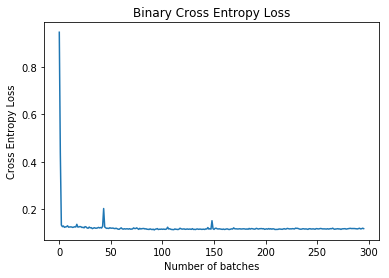

In [91]:
plt.plot(losses)
plt.title('Binary Cross Entropy Loss')
plt.xlabel('Number of batches')
plt.ylabel('Cross Entropy Loss')
plt.plot()

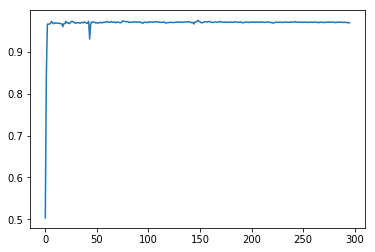

In [92]:
plt.plot(accuracies)

[]

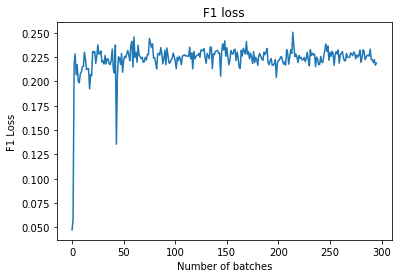

In [95]:
plt.plot(f1_scores)
plt.title('F1 loss')
plt.xlabel('Number of batches')
plt.ylabel('F1 Loss')
plt.plot()